In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

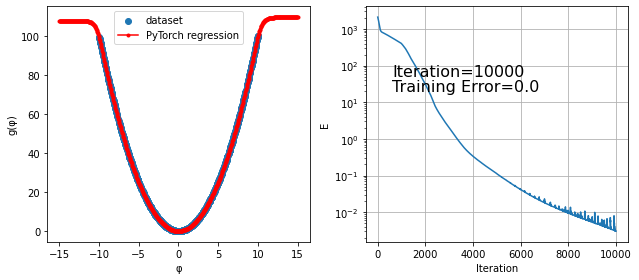

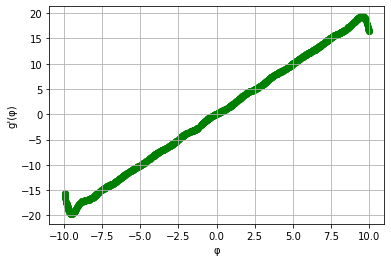

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(2, 32)
        self.linear2 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x  
    
# トレーニング関数
def train(model, optimizer, E, iteration, x, y):
    # 関数ループ
    losses = []
    for i in range(iteration):
        optimizer.zero_grad()                  # 勾配情報を０に初期化
        y_pred = model(x)                      # 予測
        loss = E(y_pred.reshape(y.shape), y)   # 損失を計算
        loss.backward()                        # 勾配の計算
        optimizer.step()                       # 勾配の更新
        losses.append(loss.item())             # 損失値の蓄積
    return model, losses

def test(model, x):
    y_pred = model(x).data.numpy().T[0] #　予測
    return y_pred

# グラフ描画関数
def plot(x, y, x_new, y_pred, losses):
    # ここからグラフ描画-------------------------------------------------
    # グラフの上下左右に目盛線を付ける。
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
 
    # 軸のラベルを設定する。
    ax1.set_xlabel("φ")
    ax1.set_ylabel("g(φ)")
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('E')
 
    # スケール設定
    ax2.set_yscale('log')
 
    # データプロット
    ax1.scatter(x, y, label='dataset')
    ax1.plot(x_new, y_pred, color='red', label='PyTorch regression', marker="o", markersize=3)
    ax2.plot(np.arange(0, len(losses), 1), losses)
    ax2.text(600, 20, 'Training Error=' + str(round(losses[len(losses)-1], 2)), fontsize=16)
    ax2.text(600, 50, 'Iteration=' + str(round(len(losses), 1)), fontsize=16)
 
    # グラフを表示する。
    ax1.legend()
    fig.tight_layout()
    plt.grid()
    plt.show()
    plt.close()
    # -------------------------------------------------------------------
    
np.random.seed(2022)
iters = 10000
    
# トレーニングデータ
x = np.random.uniform(-10, 10, 1000)                                   # x軸をランダムで作成
y = x * x                                                        
x = torch.from_numpy(x.astype(np.float32)).float()                  # xをテンソルに変換
y = torch.from_numpy(y.astype(np.float32)).float()                  # yをテンソルに変換
X = torch.stack([torch.ones(1000), x], 1)                            # xに切片用の定数1配列を結合

# テストデータ
x_test = np.linspace(-15, 15, 600)                                    # x軸を作成
x_test = torch.from_numpy(x_test.astype(np.float32)).float()        # xをテンソルに変換
X_test = torch.stack([torch.ones(600), x_test], 1)                   # xに切片用の定数1配列を結合

# ネットワークのインスタンスを生成
net = Net()

# 最適化アルゴリズムと損失関数を設定
optimizer = optim.Adam(net.parameters(), lr=0.01)                # 最適化にAdamを設定
E = nn.MSELoss()   

# トレーニング
net, losses = train(model=net, optimizer=optimizer, E=E, iteration=iters, x=X, y=y)

# テスト
y_pred = test(net, X_test)

# グラフ描画
plot(x, y, X_test.data.numpy().T[1], y_pred, losses)

extractor = torchvision.models.feature_extraction.create_feature_extractor(net, ["x", "linear1", "sigmoid", "linear2"])

W1 = net.linear1.weight
W1 = W1.cpu().detach().numpy().copy()
W1 = W1.T
W2 = net.linear2.weight
W2 = W2.cpu().detach().numpy().copy()
W2 = W2.T

U_dashs = []

for V in X:
    features = extractor(V)
    H = features["sigmoid"]
    H = H.cpu().detach().numpy().copy()
    sigmoid_dash = H * (1 - H)
    U_dash = np.dot(sigmoid_dash * W1, W2)
    U_dashs.append(U_dash[1, 0])

plt.scatter(x, U_dashs, color="g")
plt.xlabel("φ")
plt.ylabel("g'(φ)")
plt.grid()
plt.show()

In [3]:
sigma_u = 1
vp = 3
sigma_p = 1
infer_time = 10
epoch = 50000
dt = 0.08
phi = list(range(infer_time))
ep = list(range(infer_time))
eu = list(range(infer_time))

vs = [np.random.normal(5, np.sqrt(3)) for i in range(epoch)]
vps = []
sigma_ps = []
sigma_us = []
eps_1 = []
eps_2 = []
eus = []

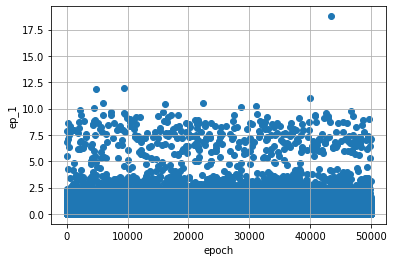

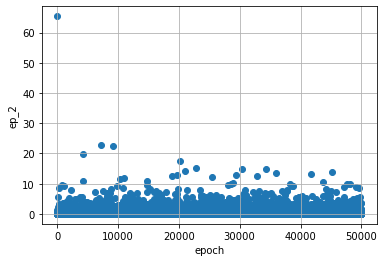

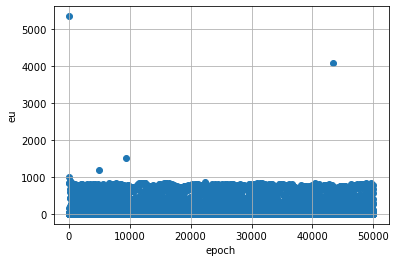

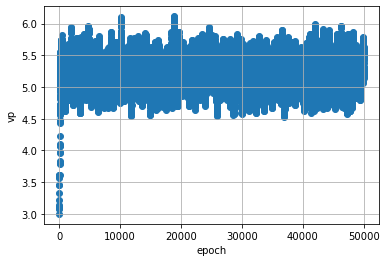

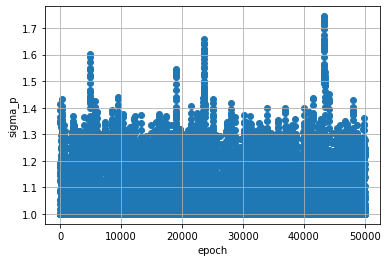

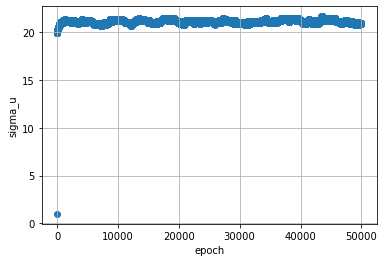

In [4]:
for i in range(epoch):
    v = vs[i]
    u = v * v
    phi[0] = vp
    ep[0] = 0
    eu[0] = 0
    
    # 推測
    for j in range(1, infer_time):
        _phi = np.array([phi[j-1]])
        _phi = np.insert(_phi, 0, 1)
        _phi = torch.from_numpy(_phi.astype(np.float32)).float()
        features = extractor(_phi)
        H = features["sigmoid"]
        H = H.cpu().detach().numpy().copy()
        sigmoid_dash = H * (1 - H)
        U = test(net, _phi)
        U_dash = np.dot(sigmoid_dash * W1, W2)
        U_dash = U_dash[1, 0]
        phi[j] = phi[j-1] + dt * (-ep[j-1] + eu[j-1] * U_dash)
        ep[j] = ep[j-1] + dt * (phi[j-1] - vp - sigma_p * ep[j-1])
        eu[j] = eu[j-1] + dt * (u - U - sigma_u * eu[j-1])
        
    eps_1.append(ep[-1] * ep[-1])
    eps_2.append((phi[-1] - v) ** 2)
    eus.append((U - u) ** 2)
    vps.append(vp)
    sigma_ps.append(sigma_p)
    sigma_us.append(sigma_u)
          
    # 注意
    vp = vp + ep[-1] * dt
    sigma_p = max(sigma_p + 1/2 * (ep[-1] ** 2 - 1/sigma_p) * dt, 1)
    sigma_u = max(sigma_u + 1/2 * (eu[-1] ** 2 - 1/sigma_u) * dt, 1) 
    
plt.scatter(range(epoch), eps_1)
plt.xlabel("epoch")
plt.ylabel("ep_1")
plt.plot()
plt.grid()
plt.show()

plt.scatter(range(epoch), eps_2)
plt.xlabel("epoch")
plt.ylabel("ep_2")
plt.plot()
plt.grid()
plt.show()

plt.scatter(range(epoch), eus)
plt.xlabel("epoch")
plt.ylabel("eu")
plt.plot()
plt.grid()
plt.show()

plt.scatter(range(epoch), vps)
plt.xlabel("epoch")
plt.ylabel("vp")
plt.plot()
plt.grid()
plt.show()

plt.scatter(range(epoch), sigma_ps)
plt.xlabel("epoch")
plt.ylabel("sigma_p")
plt.plot()
plt.grid()
plt.show()

plt.scatter(range(epoch), sigma_us)
plt.xlabel("epoch")
plt.ylabel("sigma_u")
plt.plot()
plt.grid()
plt.show()

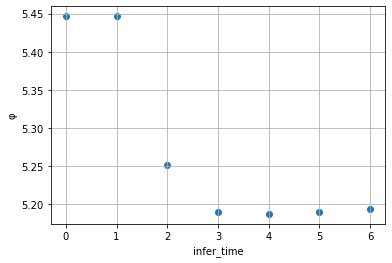

v: 5.183500720314311
vp: 5.446563400426674
sigma_p: 1
sigma_u: 20.922976301682098
phi: 5.193925190043856
u: 26.86867971749898
U: 26.907494


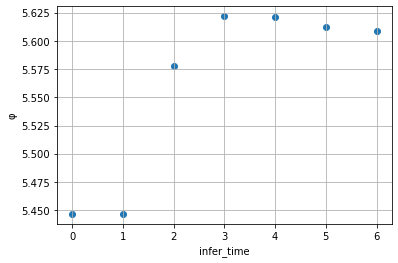

v: 5.613849578631202
vp: 5.446563400426674
sigma_p: 1
sigma_u: 20.922976301682098
phi: 5.608579956147802
u: 31.51530709149772
U: 31.499321


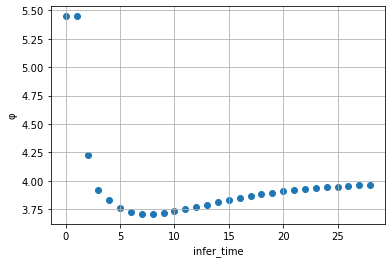

v: 3.5022636741117554
vp: 5.446563400426674
sigma_p: 1
sigma_u: 20.922976301682098
phi: 3.9648060244451733
u: 12.265850843002772
U: 15.713508


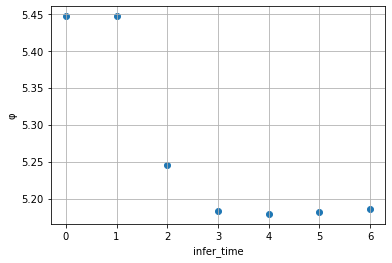

v: 5.1753008003924705
vp: 5.446563400426674
sigma_p: 1
sigma_u: 20.922976301682098
phi: 5.1859836437781635
u: 26.783738374542946
U: 26.824522


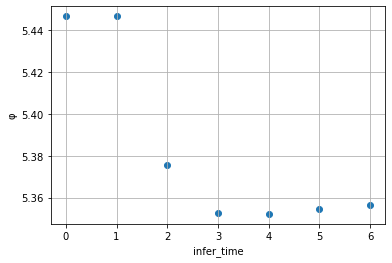

v: 5.351186723589052
vp: 5.446563400426674
sigma_p: 1
sigma_u: 20.922976301682098
phi: 5.356253853748682
u: 28.635199350715734
U: 28.645044


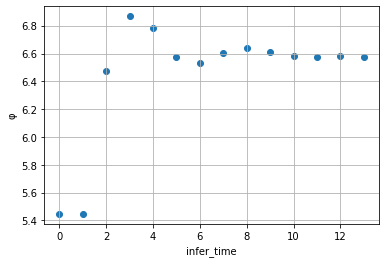

v: 6.654134293887864
vp: 5.446563400426674
sigma_p: 1
sigma_u: 20.922976301682098
phi: 6.577591527039571
u: 44.27750320109455
U: 43.286434


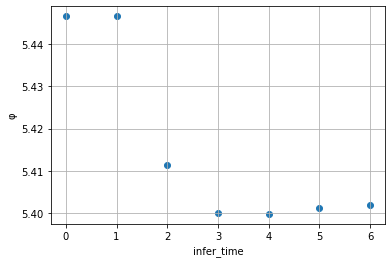

v: 5.398634675164575
vp: 5.446563400426674
sigma_p: 1
sigma_u: 20.922976301682098
phi: 5.402076184740447
u: 29.14525635588932
U: 29.149776


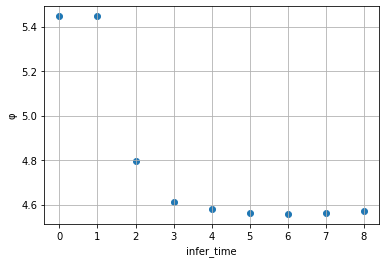

v: 4.513190361011511
vp: 5.446563400426674
sigma_p: 1
sigma_u: 20.922976301682098
phi: 4.569828281626775
u: 20.368887234727215
U: 20.831448


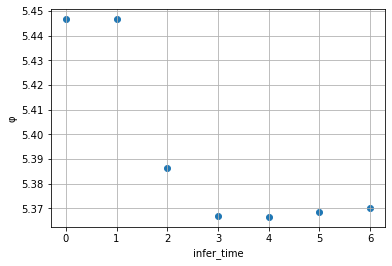

v: 5.365399892540774
vp: 5.446563400426674
sigma_p: 1
sigma_u: 20.922976301682098
phi: 5.369988248928755
u: 28.787516006876547
U: 28.79568


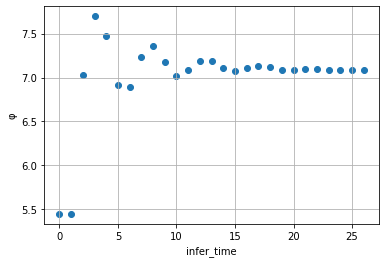

v: 7.22765711334171
vp: 5.446563400426674
sigma_p: 1
sigma_u: 20.922976301682098
phi: 7.083901942782729
u: 52.23902734803902
U: 50.12319


In [16]:
vs = [np.random.normal(5, np.sqrt(3)) for i in range(10)]

for i in range(10):
    v = vs[i]
    u = v * v
    
    infer_time = 100
    end = False
    phi = list(range(infer_time))
    ep = list(range(infer_time))
    eu = list(range(infer_time))
    phi[0] = vp
    ep[0] = 0
    eu[0] = 0
    phis = []
    phis.append(phi[0])
    
    # 推測
    for j in range(1, infer_time):
        _phi = np.array([phi[j-1]])
        _phi = np.insert(_phi, 0, 1)
        _phi = torch.from_numpy(_phi.astype(np.float32)).float()
        features = extractor(_phi)
        H = features["sigmoid"]
        H = H.cpu().detach().numpy().copy()
        sigmoid_dash = H * (1 - H)
        U = test(net, _phi)
        U_dash = np.dot(sigmoid_dash * W1, W2)
        U_dash = U_dash[1, 0]
        phi[j] = phi[j-1] + dt * (-ep[j-1] + eu[j-1] * U_dash)
        ep[j] = ep[j-1] + dt * (phi[j-1] - vp - sigma_p * ep[j-1])
        eu[j] = eu[j-1] + dt * (u - U - sigma_u * eu[j-1])
        
        phis.append(phi[j])
        
        if j > 3:
            blur = (phi[j] - phi[j-1])**2 + (phi[j-1] - phi[j-2])**2 + (phi[j-2] - phi[j-3])**2
            if blur < 0.0001:
                end = True
            
        
        if end:
            infer_time = j + 1
            break
            
    plt.scatter(range(infer_time), phis)
    plt.xlabel("infer_time")
    plt.ylabel("φ")
    plt.plot()
    plt.grid()
    plt.show()
    
    print("v:", v)
    print("vp:", vp)
    print("sigma_p:", sigma_p)
    print("sigma_u:", sigma_u)
    print("phi:", phis[-1])
    print("u:", u)
    print("U:", U)